In [1]:
import pandas as pd
import numpy as np
from scipy import stats, signal
from tqdm import trange, tqdm
from matplotlib.pyplot import *

%matplotlib inline

In [2]:
# figure styling
import seaborn as sns
sns.set(style='ticks', palette='colorblind')

rcParams['figure.figsize'] = (13,4.5)
rcParams['figure.dpi'] = 200

In [483]:
images = np.load('../data/stim.npy')

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/sub.csv')

dd = np.load('../data/features.npz')
features = dict()
for k in dd.keys():
    features[k] = dd[k]

    
conv_train = np.load('../data/conv_train.npy').flat[0]
conv_test = np.load('../data/conv_test.npy').flat[0]

conv_features = dict()
for k in conv_train.keys():
    conv_features[k] = np.vstack([conv_test[k], conv_train[k]])

In [64]:
features.keys()

dict_keys(['raw', 'LAB', 'fourier', 'gabor', 'stats'])

In [484]:
conv_features.keys()

dict_keys(['conv1', 'conv2', 'conv3', 'conv4', 'conv5'])

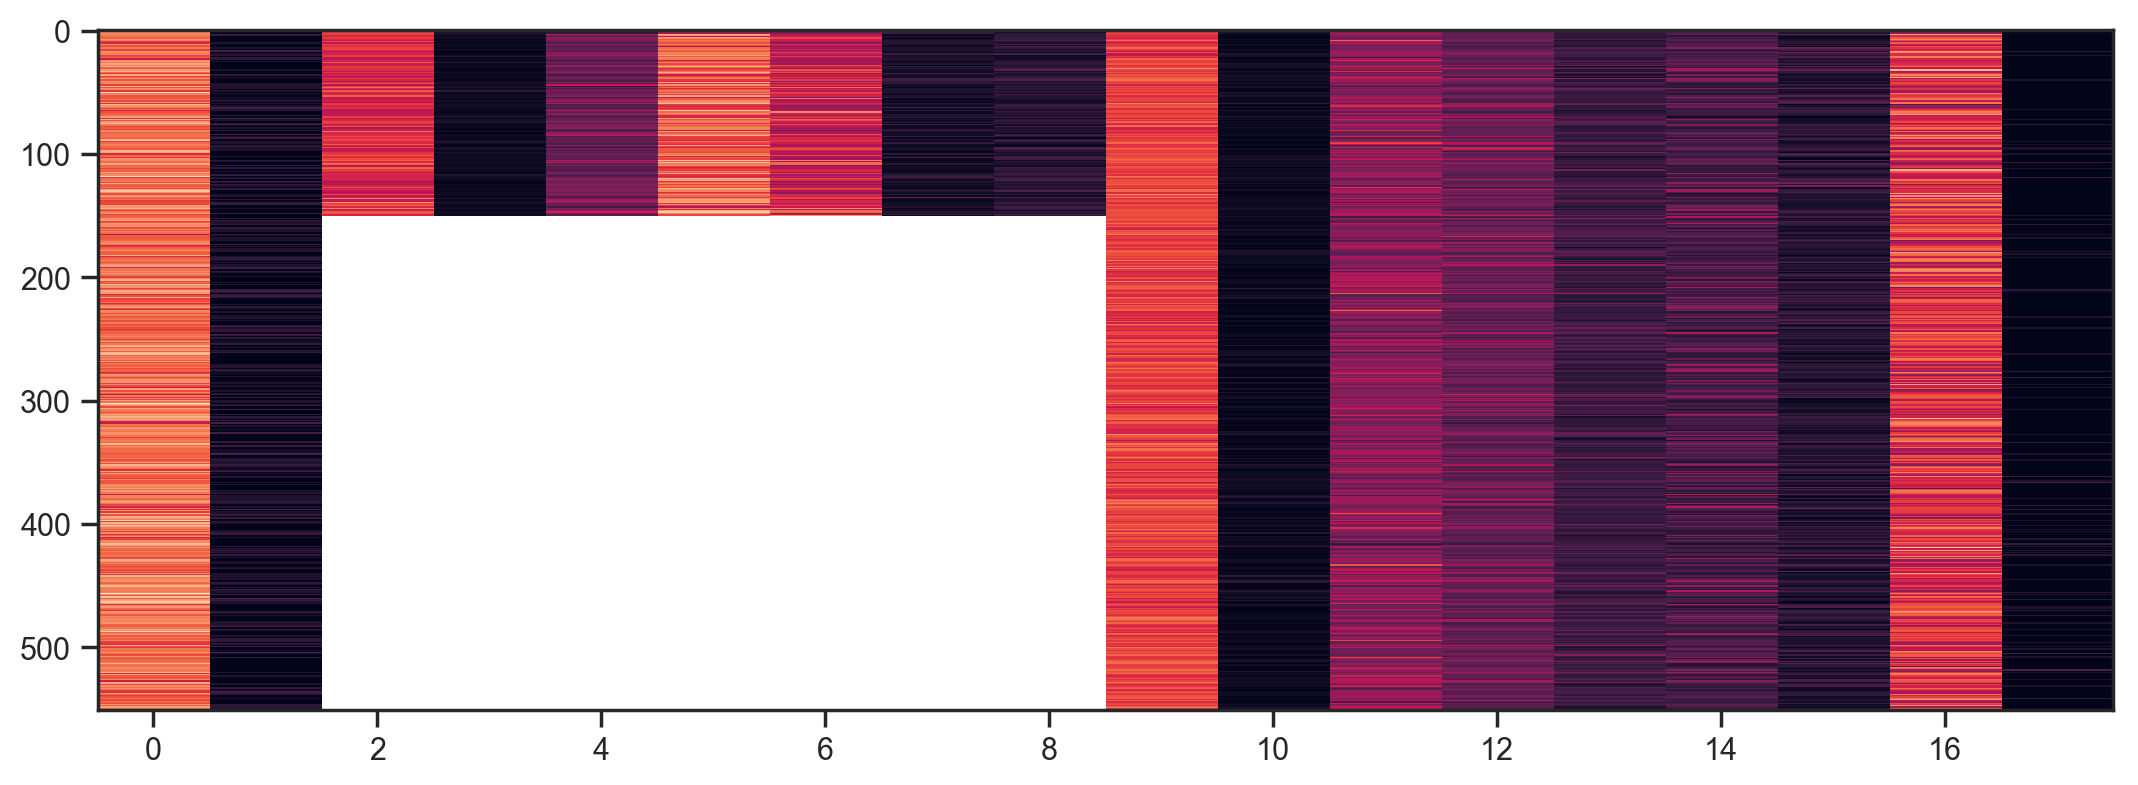

In [4]:
responses = np.array(train.iloc[:, 1:])

imshow(responses, aspect='auto')

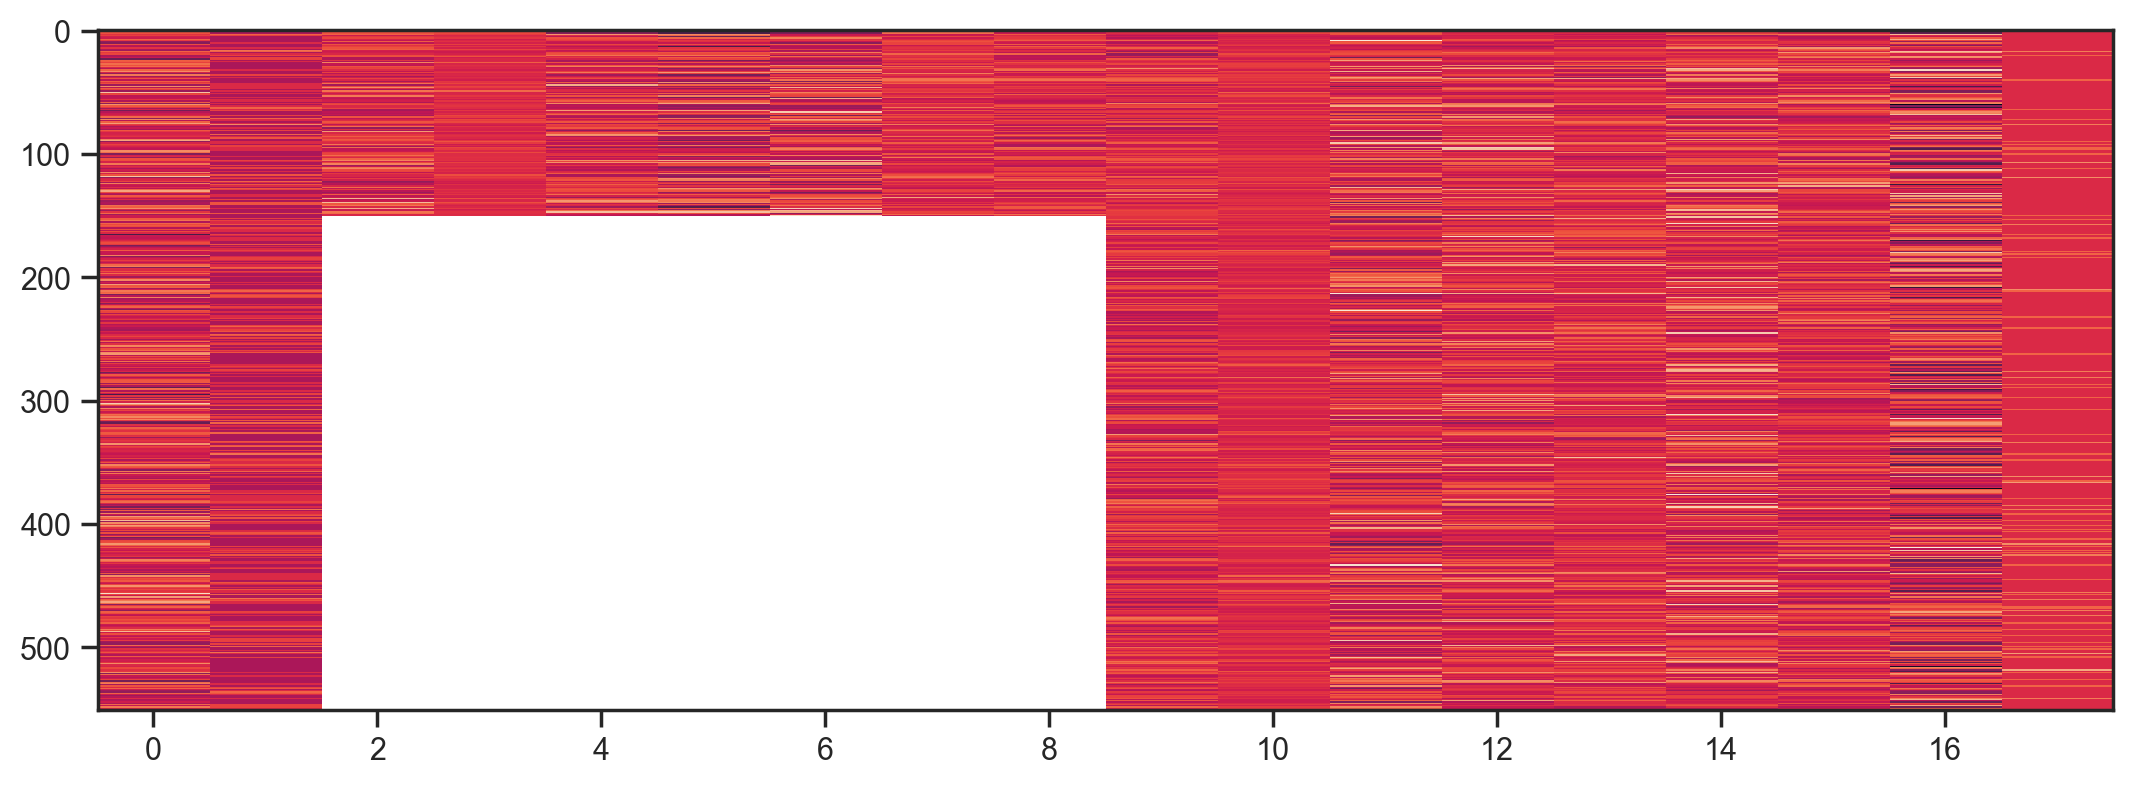

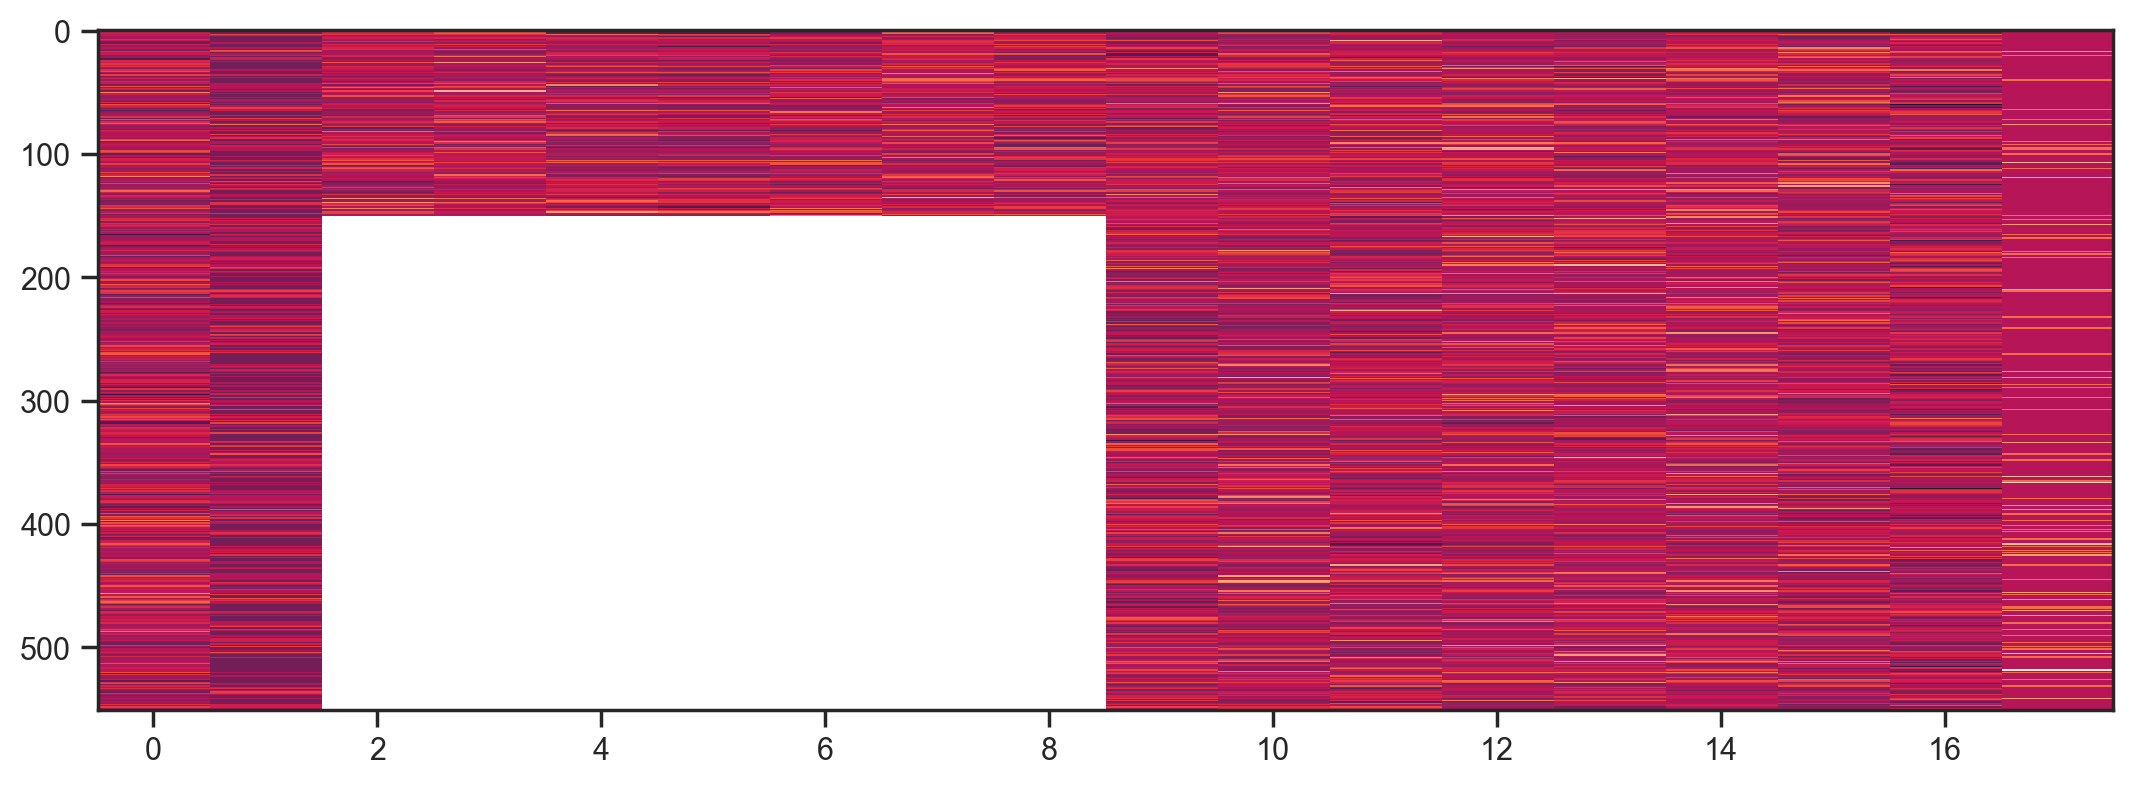

In [5]:
responses_demean = np.copy(responses)
responses_std = np.copy(responses)

means = []
stds = []

for r in range(responses.shape[1]):
    vals = responses[:, r]
    vs = vals[~np.isnan(vals)]
    responses_demean[:, r] = vals - np.median(vs)
    responses_std[:, r] = (vals - np.median(vs)) / np.std(vs)
    
    means.append(np.median(vs))
    stds.append(np.std(vs))
    
means = np.array(means)
stds = np.array(stds)
    
imshow(responses_demean, aspect='auto')

figure()
imshow(responses_std, aspect='auto')

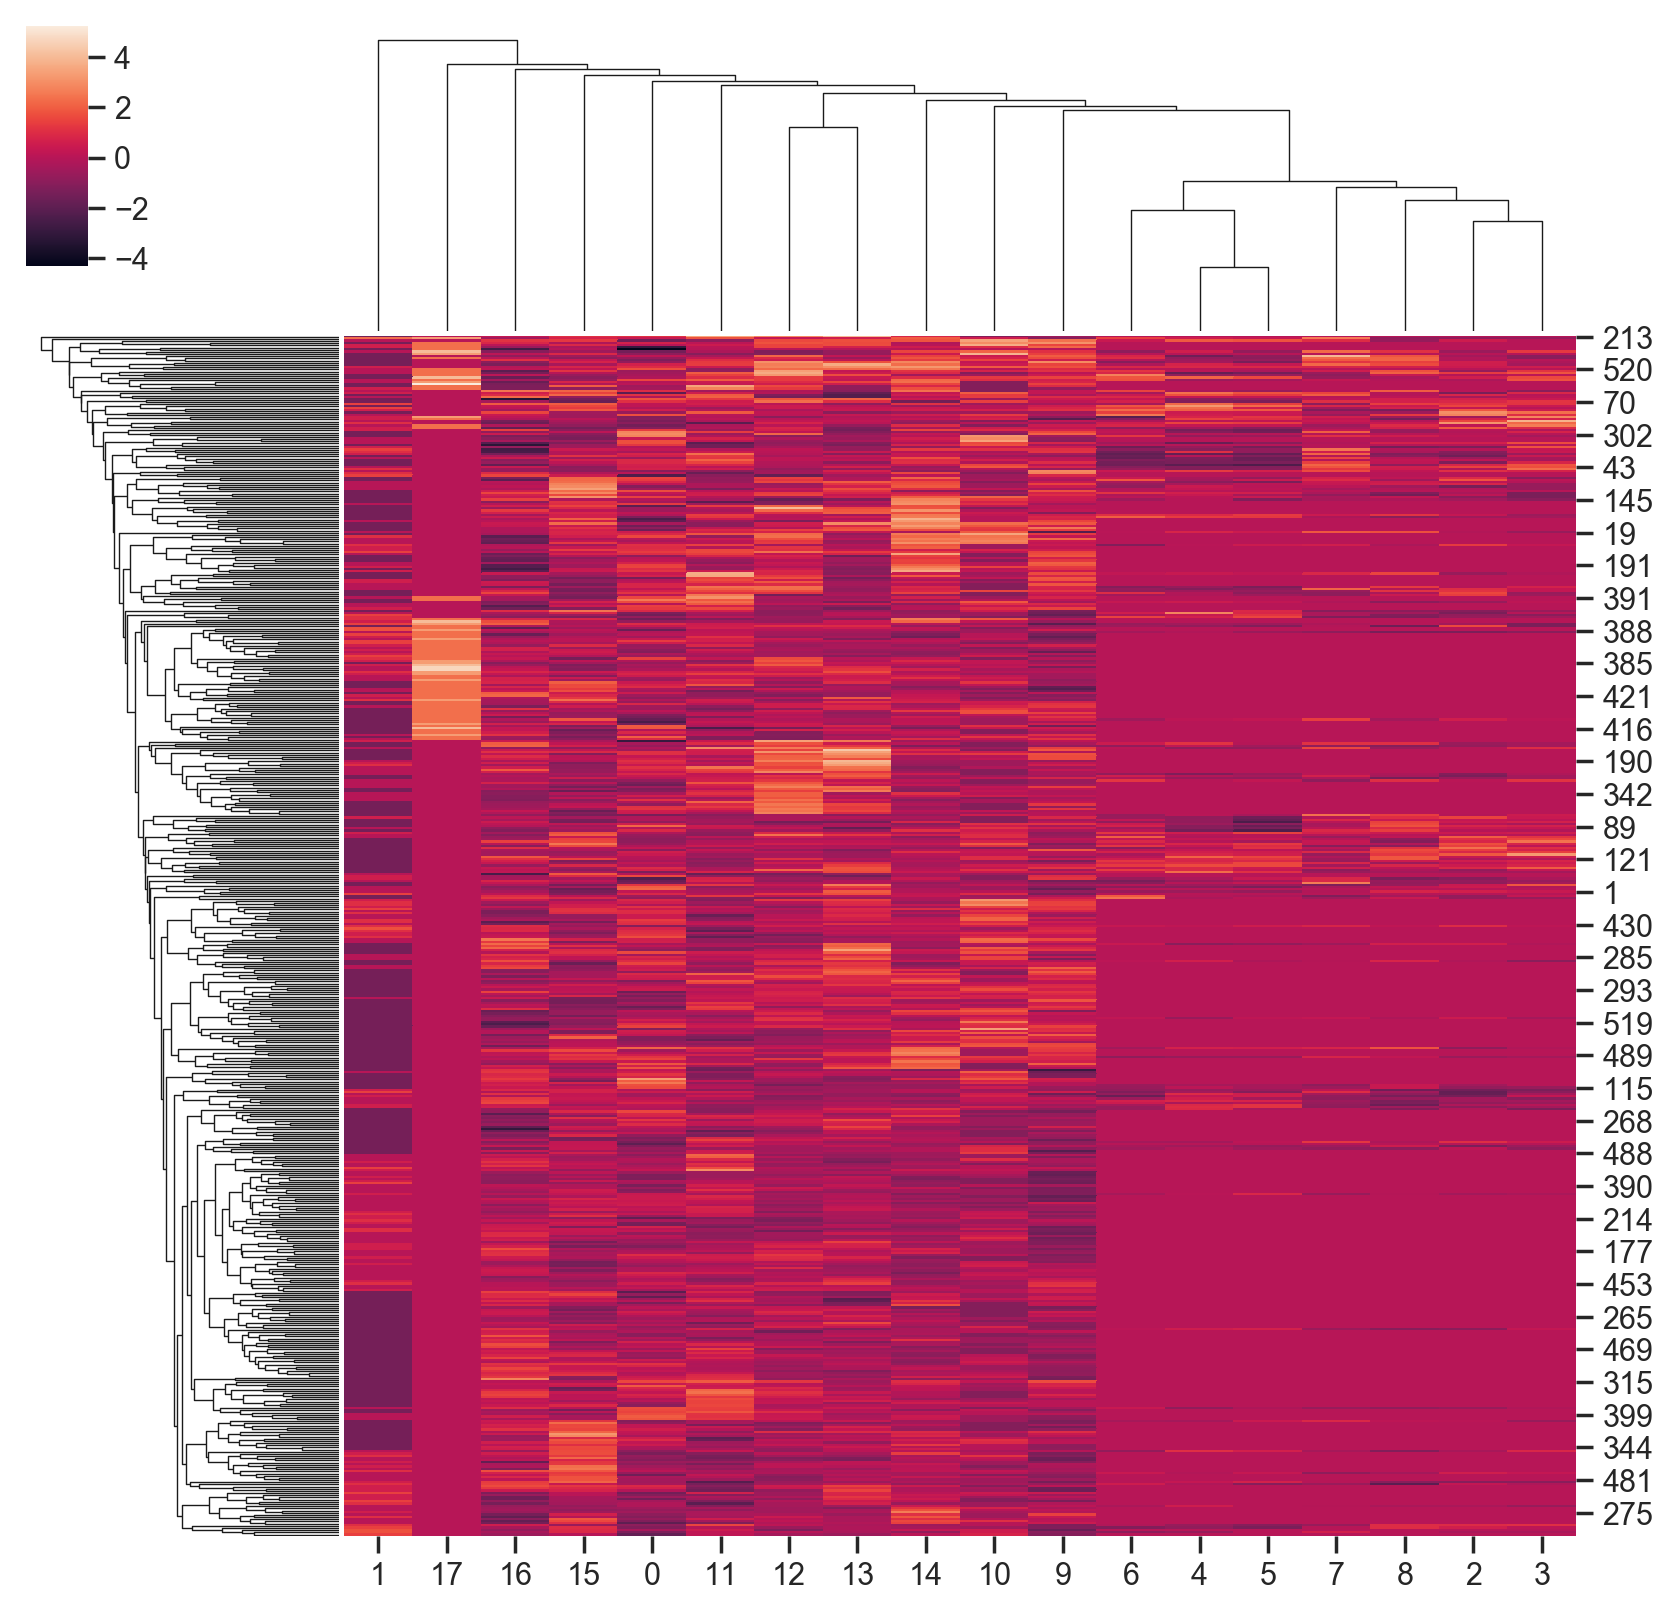

In [6]:
responses_filled = np.copy(responses_std)
responses_filled[np.isnan(responses)] = 0
sns.clustermap(responses_filled)

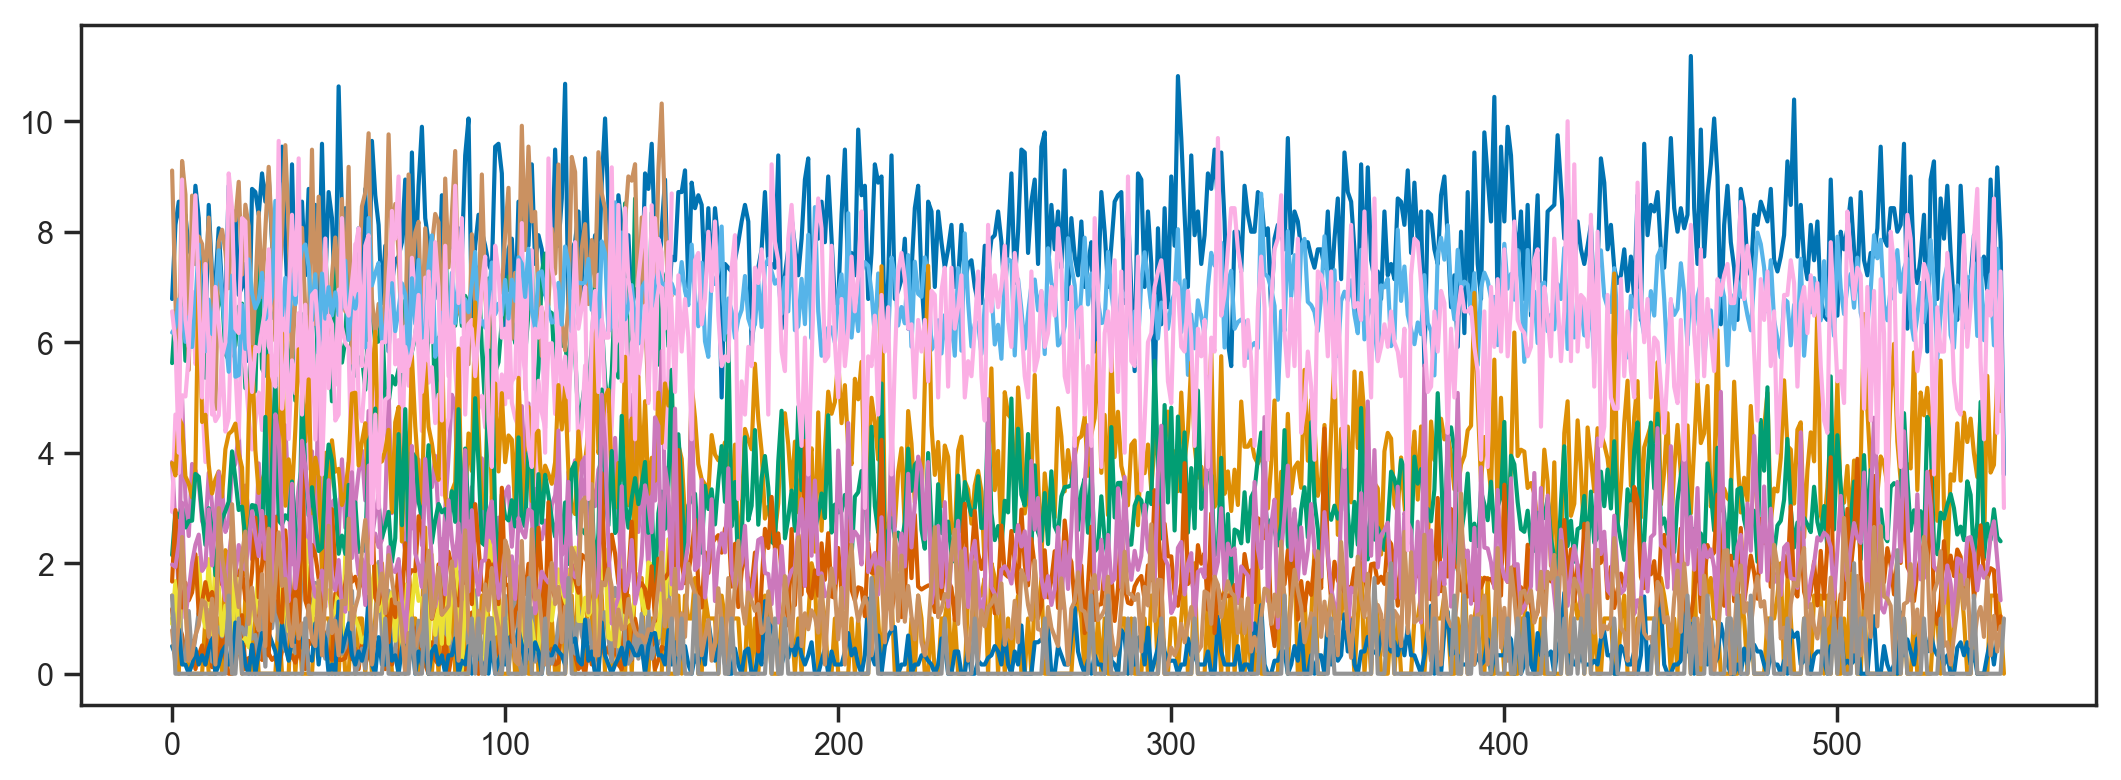

In [7]:
_ = plot(responses)

Using TensorFlow backend.


Imputing row 1/551 with 0 missing, elapsed time: 0.064
Imputing row 101/551 with 0 missing, elapsed time: 0.065
Imputing row 201/551 with 7 missing, elapsed time: 0.070
Imputing row 301/551 with 7 missing, elapsed time: 0.079
Imputing row 401/551 with 7 missing, elapsed time: 0.089
Imputing row 501/551 with 7 missing, elapsed time: 0.098


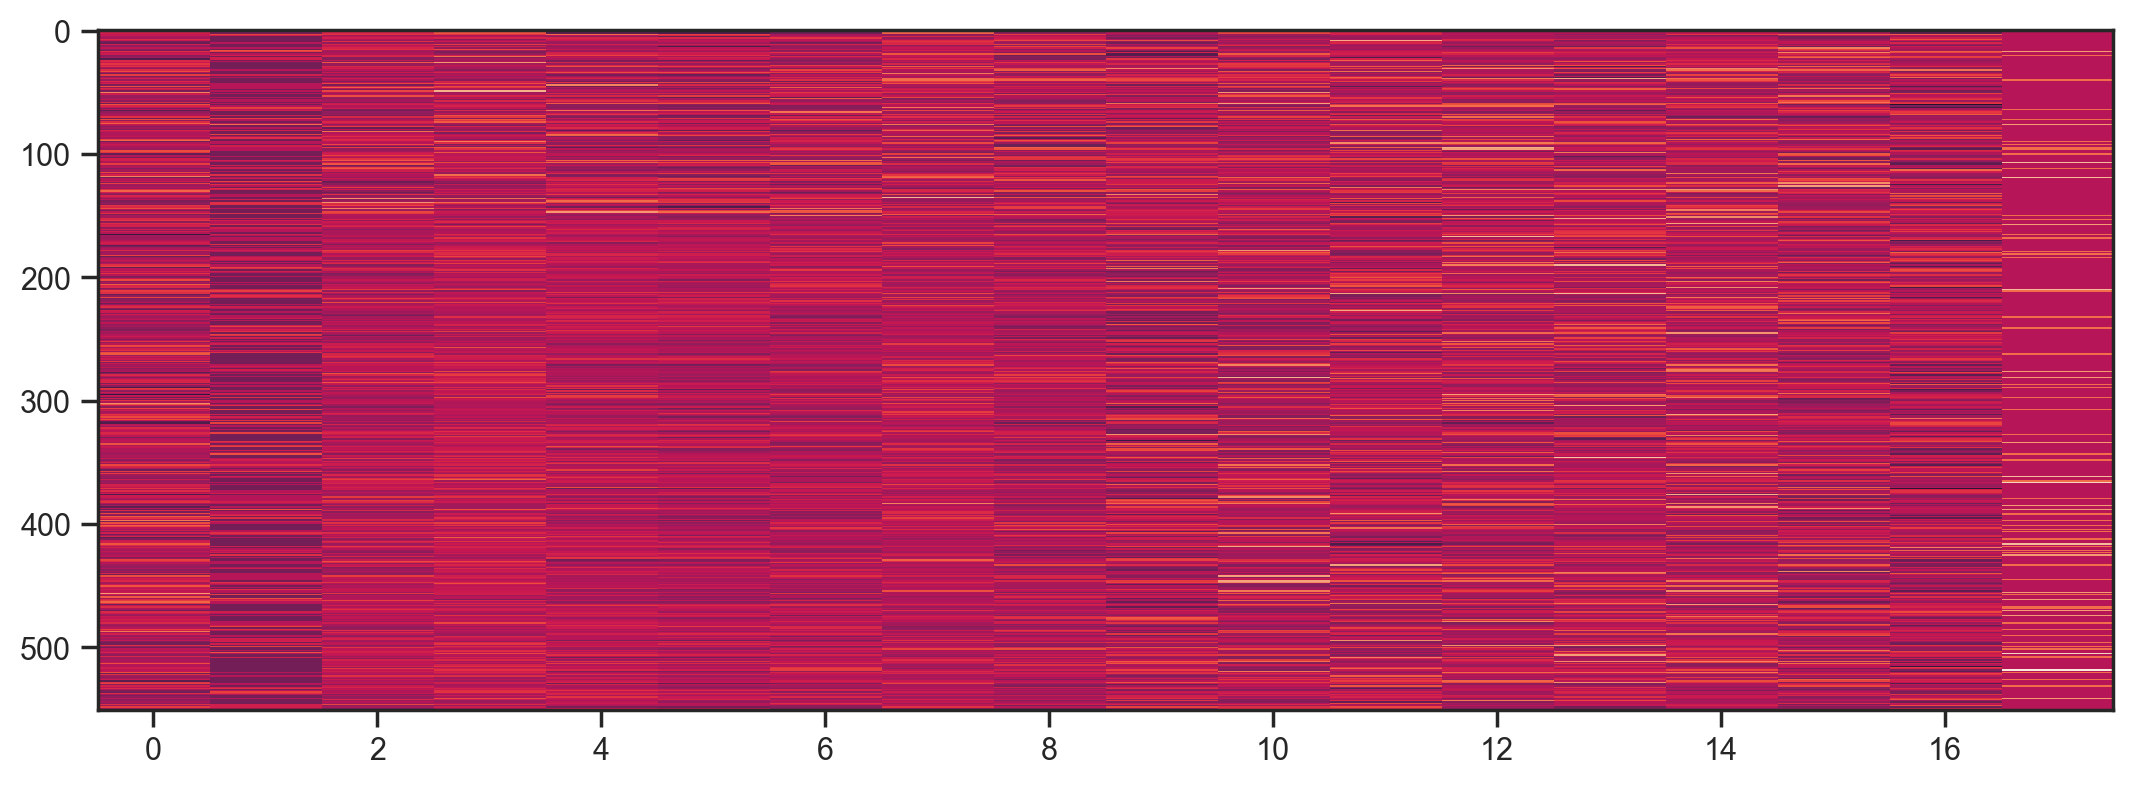

In [8]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

responses_imputed = KNN(k=3).fit_transform(responses_std)
# responses_imputed = SoftImpute().fit_transform(responses_std)

imshow(responses_imputed, aspect='auto')

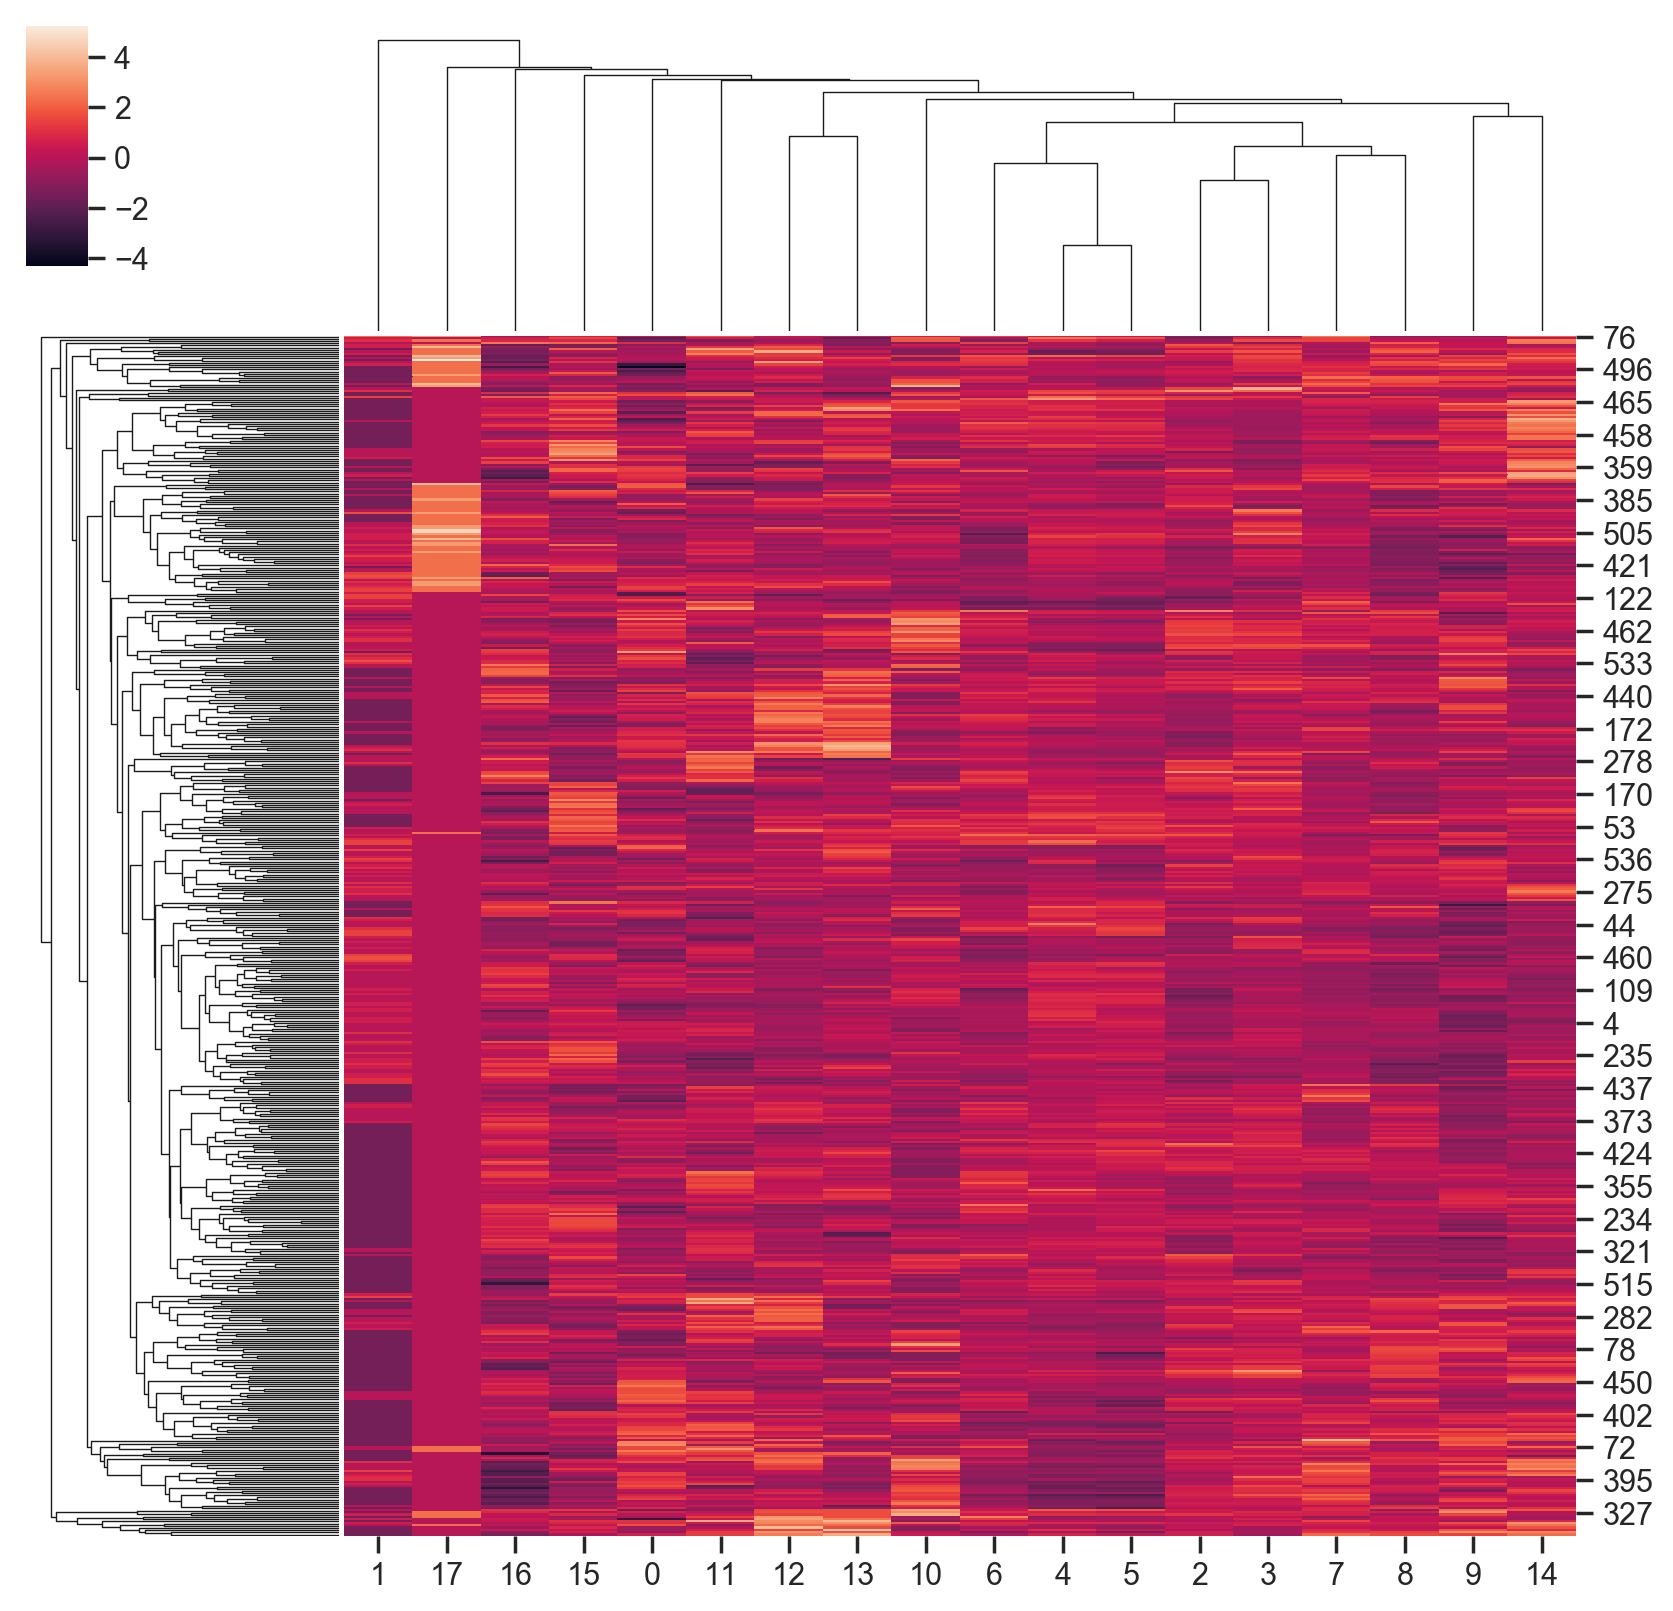

In [9]:
sns.clustermap(responses_imputed)

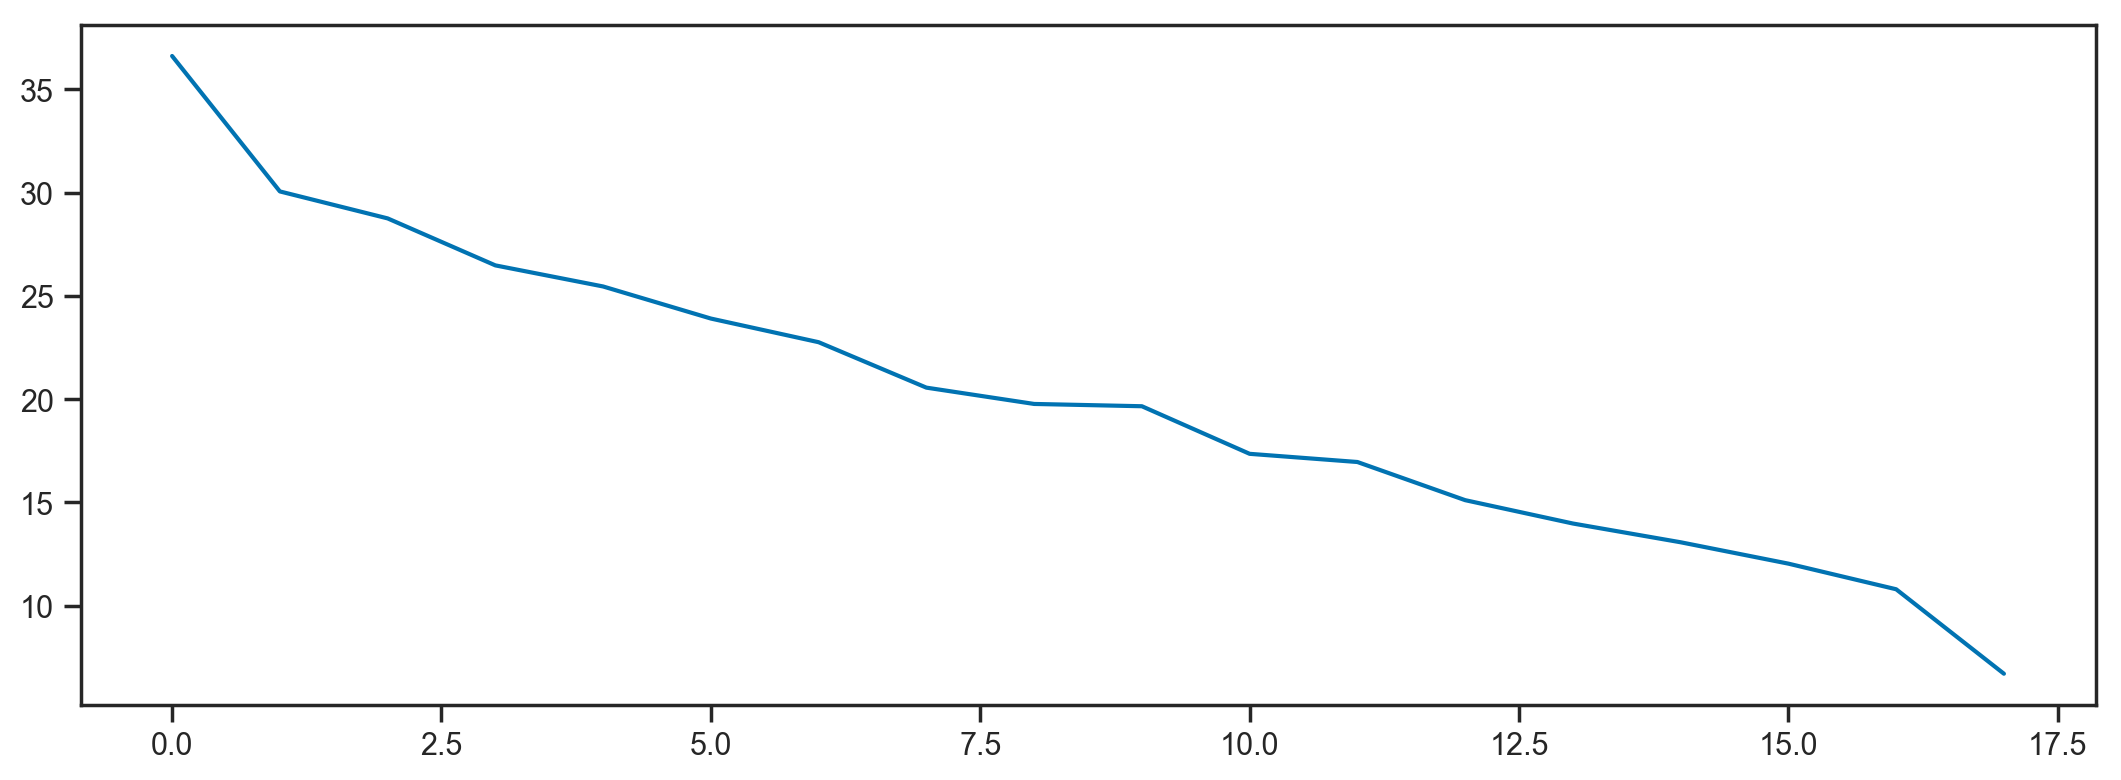

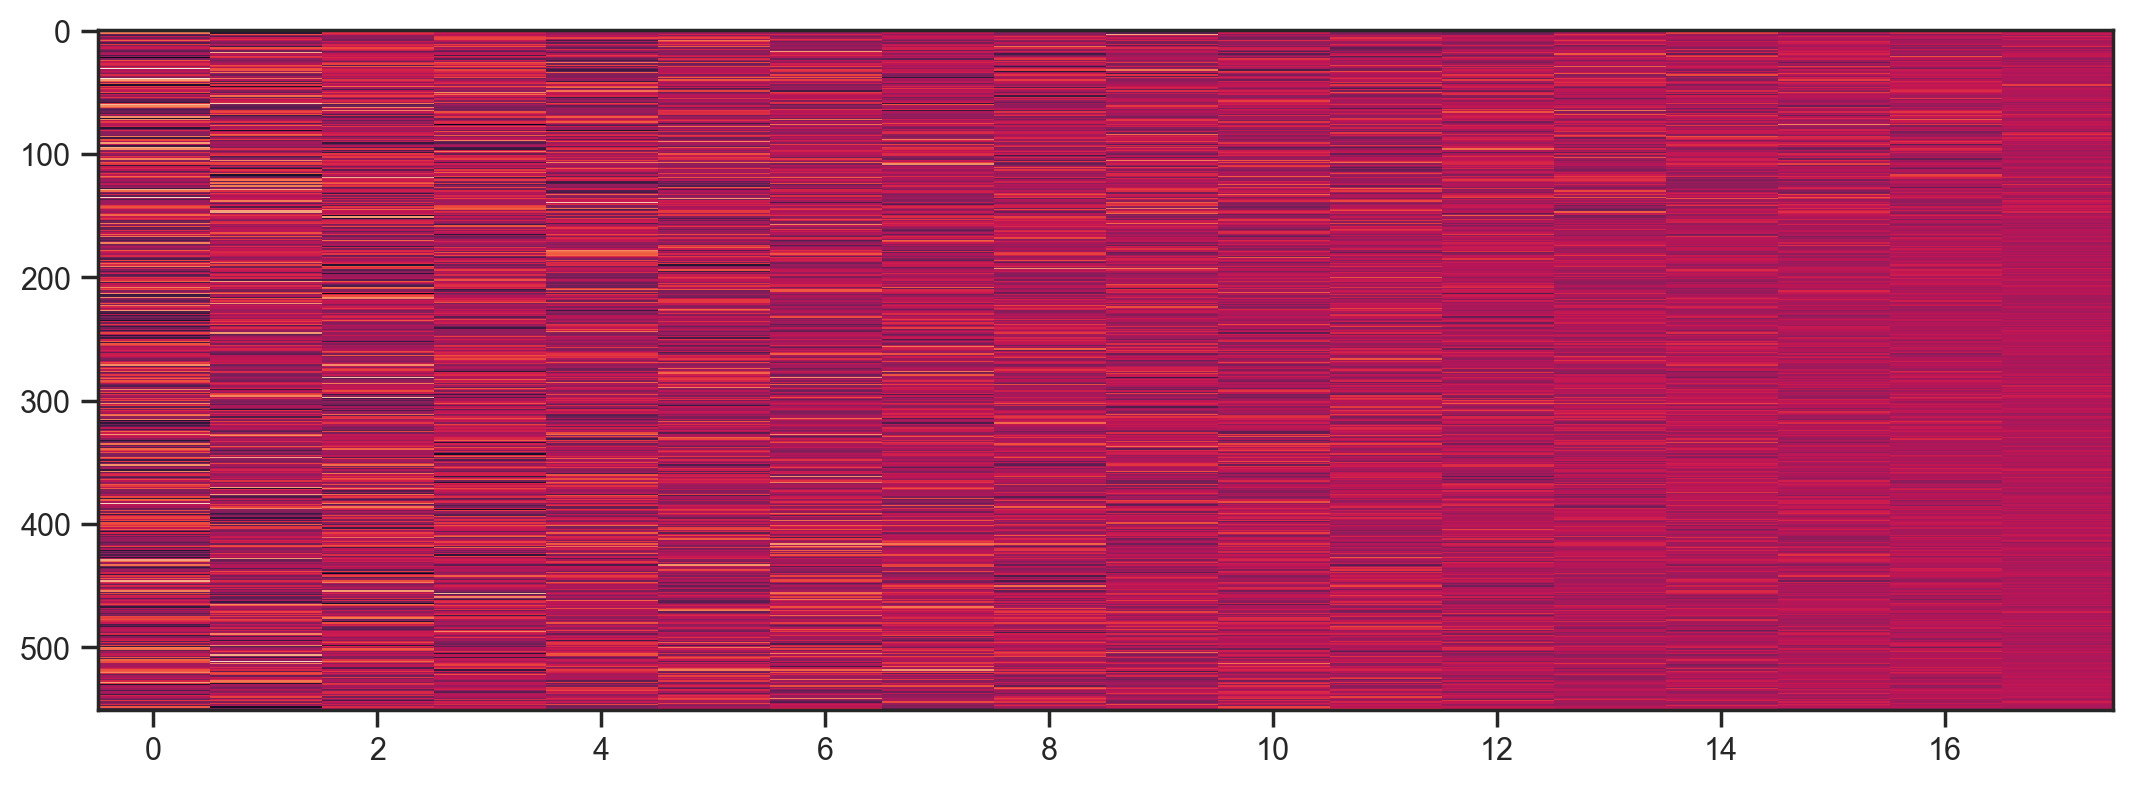

In [10]:
from sklearn.decomposition import PCA, FastICA

pca = PCA()

pca.fit(responses_imputed)
figure()
plot(pca.singular_values_)

responses_pc = pca.fit_transform(responses_imputed)
figure()
imshow(responses_pc, aspect='auto')

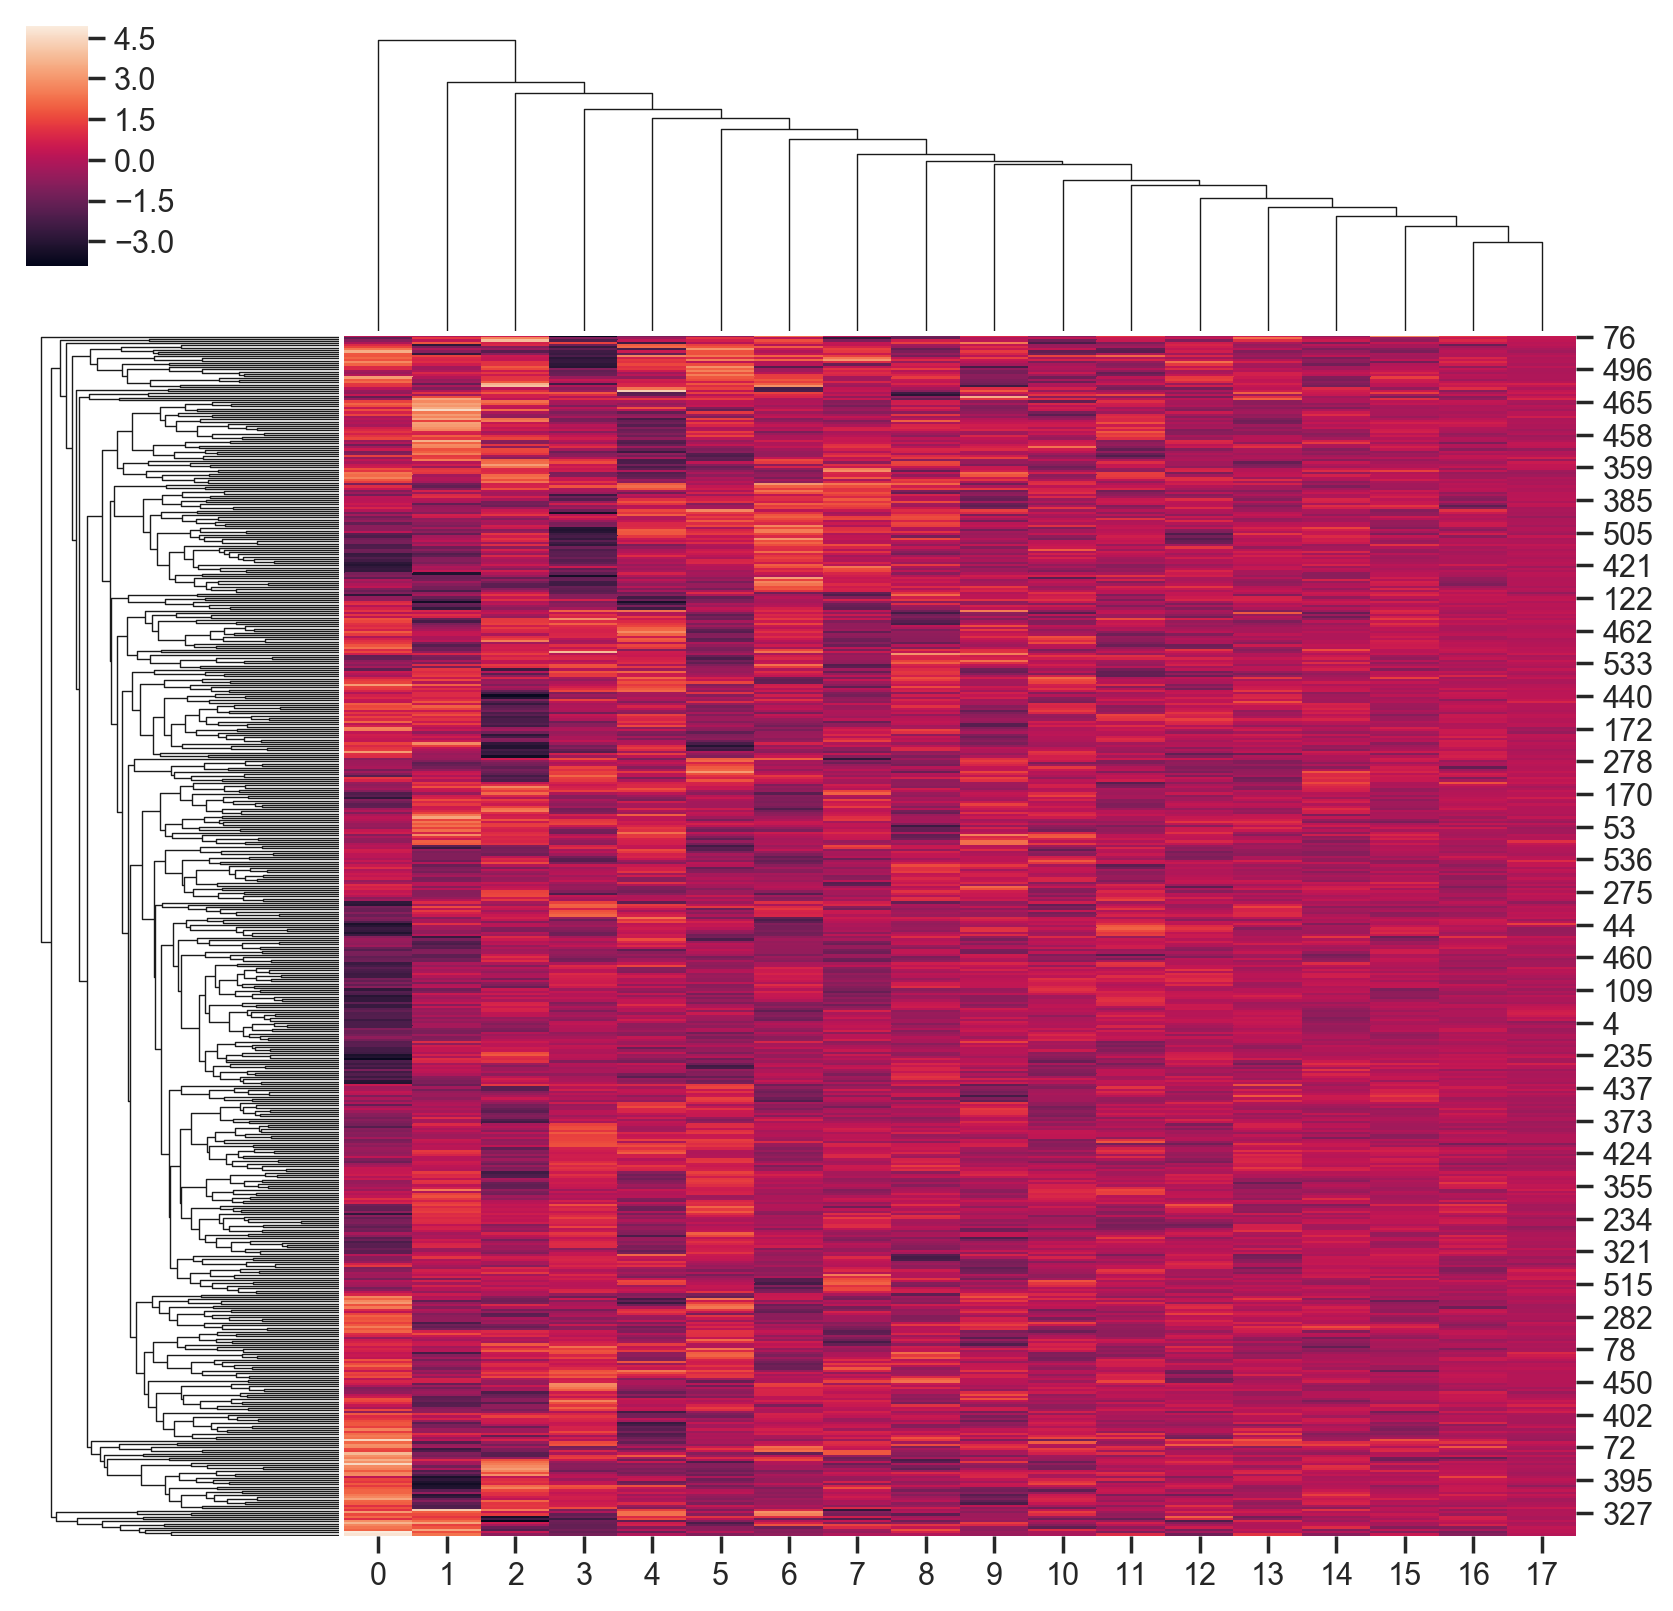

In [11]:
sns.clustermap(responses_pc)

In [12]:
def get_mega_image(images, ncols=5):
    rows = []
    row = []
    for i, im in enumerate(images):
        row.append(im[20:-20, 20:-20])
        if (i+1) % ncols == 0:
            rows.append(np.hstack(row))
            row = []
    if len(row) > 0:
        black = np.zeros(row[0].shape)
        while len(row) < ncols:
            row.append(black)
        rows.append(np.hstack(row))
    im = np.vstack(rows)
    return im

def visualize_images(images, ncols=5):
    im = get_mega_image(images, ncols)
    imshow(im)
    axis('off')

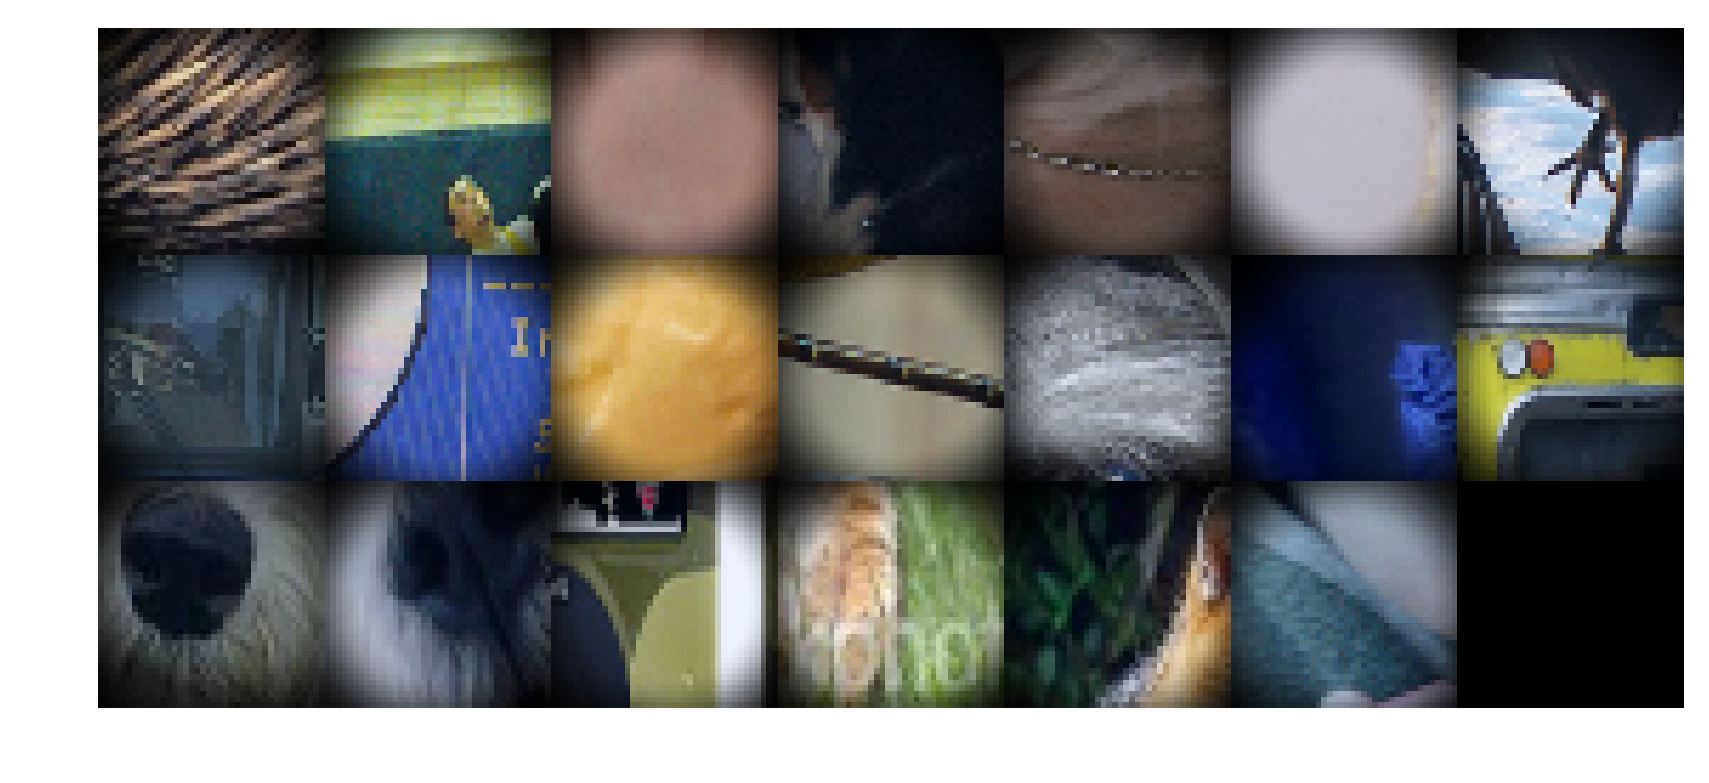

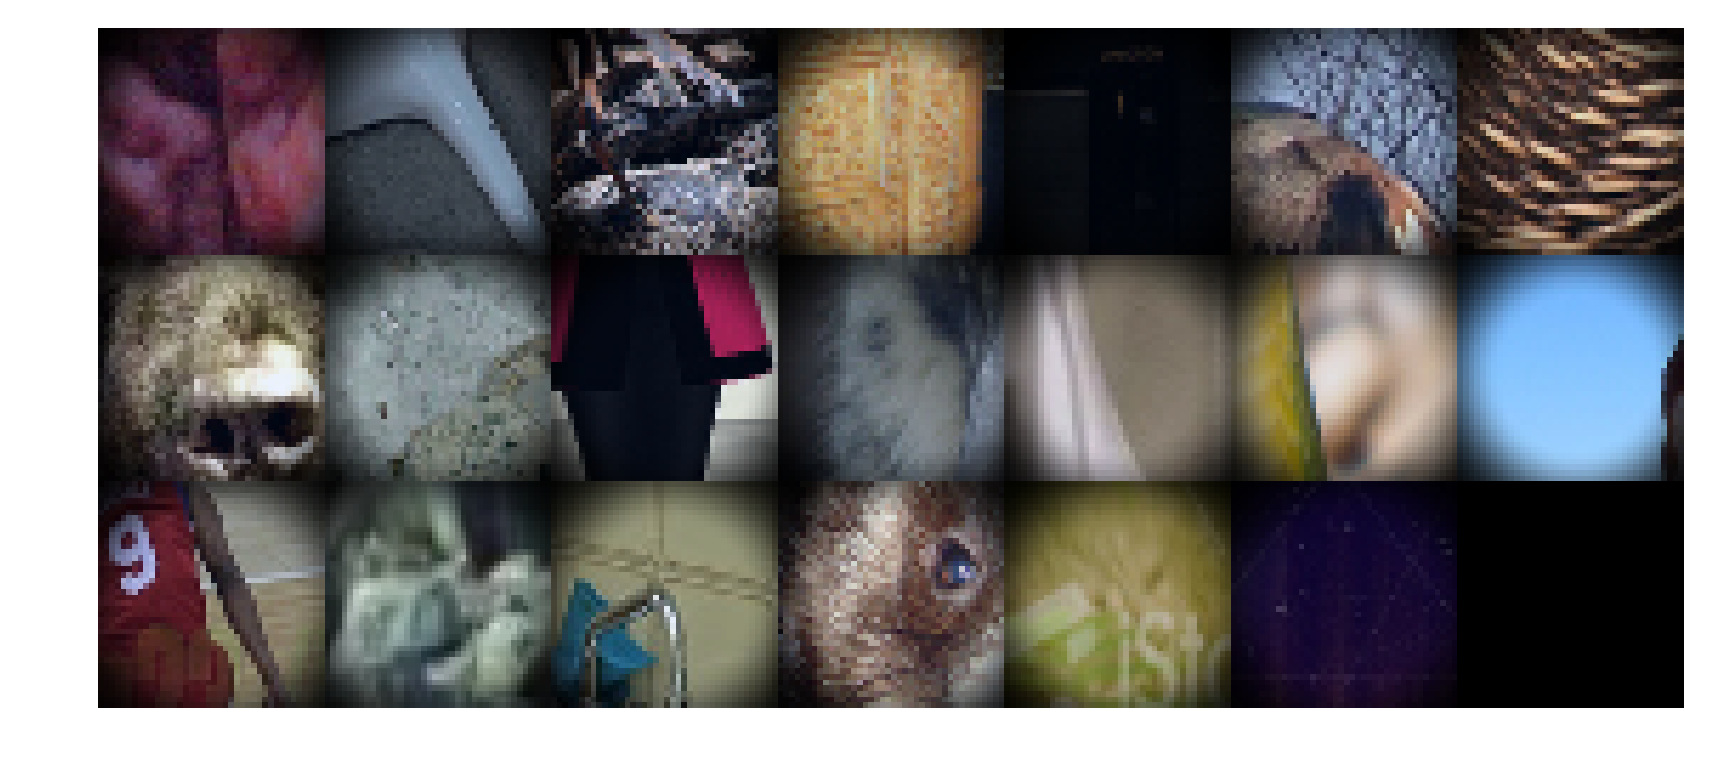

In [13]:
vals = responses_std[:, 1]
high = np.argsort(-vals)[:20]
figure()
visualize_images(images[high], ncols=7)

high = np.argsort(vals)[:20]
figure()
visualize_images(images[high], ncols=7)

In [14]:
import umap

In [15]:
for i in range(responses.shape[1]):
    for j in range(X.shape[1]):
        s = stats.linregress(X[50:,j], responses_imputed[:, i])
        print('p = {:.3g}, r = {:.3f}'.format(s.pvalue, s.rvalue))
    print('')

NameError: name 'X' is not defined

In [261]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics.scorer import make_scorer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR




In [488]:
conv_features.keys()

dict_keys(['conv1', 'conv2', 'conv3', 'conv4', 'conv5'])

In [353]:
pcs_lab = PCA(n_components=50).fit_transform(features['LAB'])
pcs_fourier = PCA(n_components=20).fit_transform(features['fourier'])
pcs_gabor = PCA(n_components=20).fit_transform(features['gabor'])

In [591]:
pcs_conv1 = PCA(n_components=30).fit_transform(conv_features['conv1'])
pcs_conv2 = PCA(n_components=20).fit_transform(conv_features['conv2'])
pcs_conv3 = PCA(n_components=20).fit_transform(conv_features['conv3'])
pcs_conv4 = PCA(n_components=20).fit_transform(conv_features['conv4'])
pcs_conv5 = PCA(n_components=10).fit_transform(conv_features['conv5'])


In [585]:
images_flat = images[:, 20:-20,20:-20].reshape(images.shape[0], -1)
# images_flat = images.reshape(images.shape[0], -1)
pcs_raw = PCA(n_components=50).fit_transform(images_flat)

embedding = umap.UMAP(metric='correlation', min_dist=1.0, n_components=50)
X_embed = embedding.fit_transform(images_flat)

In [600]:
# X_all = np.hstack([X_embed, features['stats'], pcs_lab, pcs_gabor])
# X_all = np.hstack([X_embed, features['stats'], pcs_conv4, pcs_conv5])
# X_all = np.hstack([X_embed, features['stats'], pcs_conv1, pcs_conv2, pcs_conv3, pcs_conv4, pcs_conv5])
# X_all = np.hstack([X_embed, features['stats'], pcs_conv3, pcs_conv4])
X_all = np.hstack([X_embed, features['stats'], pcs_lab, pcs_conv1, pcs_conv4, pcs_conv5])

# X_all = np.hstack([conv_features['conv1'], conv_features['conv4'], conv_features['conv5']])

In [608]:
# model = Ridge(alpha=5)
# model = Lasso(alpha=5)
# model = RidgeCV()
model = ExtraTreesRegressor(max_depth=15, n_estimators=100)
# model = KNeighborsRegressor(n_neighbors=10)
# model = SVR('rbf')

all_scores = []
for i in range(responses.shape[1]):
    vals = responses[:, i]
    good = ~np.isnan(vals)
    scores = cross_val_score(model, X_all[50:][good], vals[good], 
                             scoring=make_scorer(mean_squared_error), cv=3)
    print(i, np.mean(scores))
    all_scores.append(np.mean(scores))
    
print(np.mean(all_scores))
print(np.sqrt(np.mean(all_scores)))

0 0.8918950213470264
1 0.44973166233959533
2 0.4774047306566285
3 0.06961226565623434
4 0.5913704401345343
5 1.0549819029593204
6 1.0873654047071333
7 0.22833920674005292
8 0.27198813679892847
9 0.27653034757462835
10 0.0845374385782111
11 0.654521976892122
12 0.4778545399440293
13 0.32543832623105956
14 0.5009729943428424
15 0.33635305016078076
16 1.2031934720277198
17 0.20517988133000845
0.5104039332456032
0.714425596717813


In [609]:
new_test = test.copy()

for i in trange(responses.shape[1]):
    vals = responses[:, i]
    good = ~np.isnan(vals)
    model.fit(X_all[50:][good], vals[good])
    pred = model.predict(X_all[:50])
    new_test.iloc[:, i+1] = pred

100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


In [610]:
new_test.to_csv('../data/output_umap_nnet.csv', index=False)

In [743]:
# model = Ridge(alpha=1000)
# model = RidgeCV()
model = ExtraTreesRegressor(max_depth=5, n_estimators=100)
# model = KNeighborsRegressor(n_neighbors=100)

pca = PCA()
pca.fit(responses_imputed)
responses_pc = pca.fit_transform(responses_imputed)

all_scores = []
for i in range(responses_pc.shape[1]):
    vals = responses_pc[:, i]
    good = ~np.isnan(vals)
    scores = cross_val_score(model, X_all[50:][good], vals[good], 
                             scoring=make_scorer(r2_score))
    print(i, np.mean(scores))
    all_scores.append(np.mean(scores))
    
print(np.mean(all_scores))

0 0.5119205001293862
1 0.1833574667175266
2 0.2983670103785427
3 0.05965966465509761
4 0.028634845218468485
5 0.12647524079788008
6 -0.04736802314378504
7 -0.010057767777948793
8 0.033939169065656784
9 -0.055972018608514716
10 0.005541692807915795
11 0.014226355301213486
12 -0.041990582429831
13 -0.09415518581806803
14 0.005820739458908523
15 -0.047303133533952435
16 -0.022403655725795463
17 -0.03588277537458621
0.05071164122878414


In [744]:
responses_pc_pred = []

for i in range(responses_pc.shape[1]):
    vals = responses_pc[:, i]
    good = ~np.isnan(vals)
    model.fit(X_all[50:][good], vals[good])
    pred = model.predict(X_all[:50])
    responses_pc_pred.append(pred)
    
responses_pc_pred = np.array(responses_pc_pred).T

responses_pred_raw = pca.inverse_transform(responses_pc_pred)
responses_pred = responses_pred_raw * stds + means

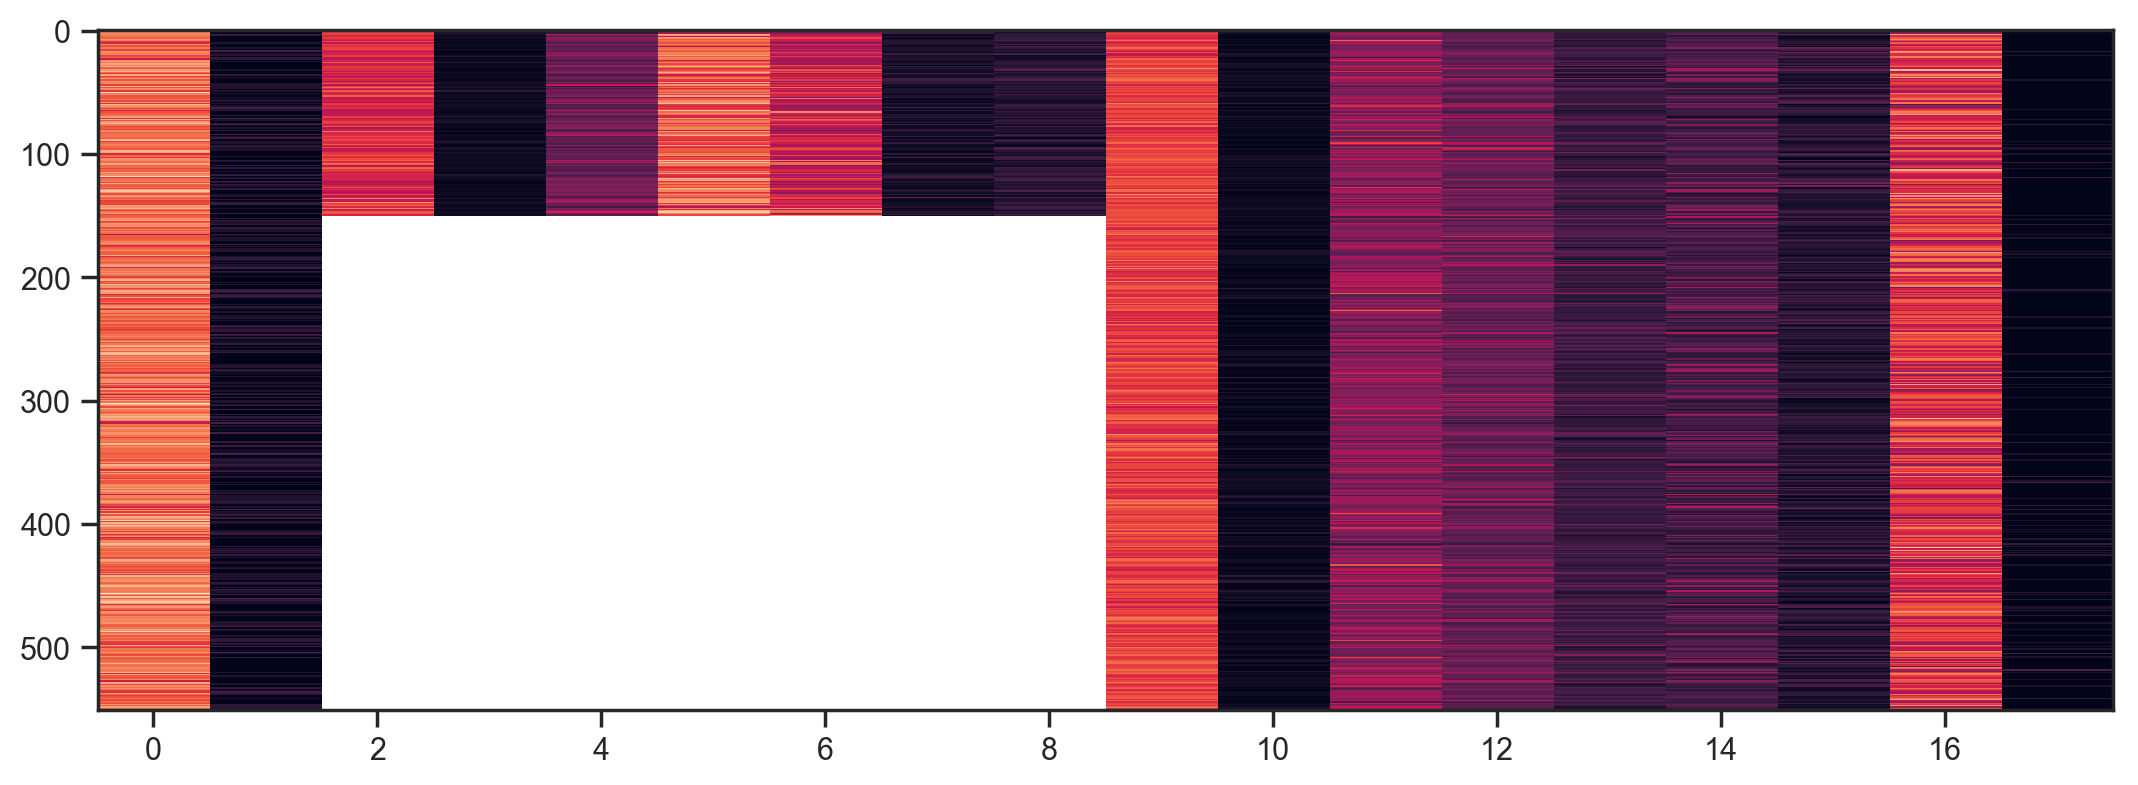

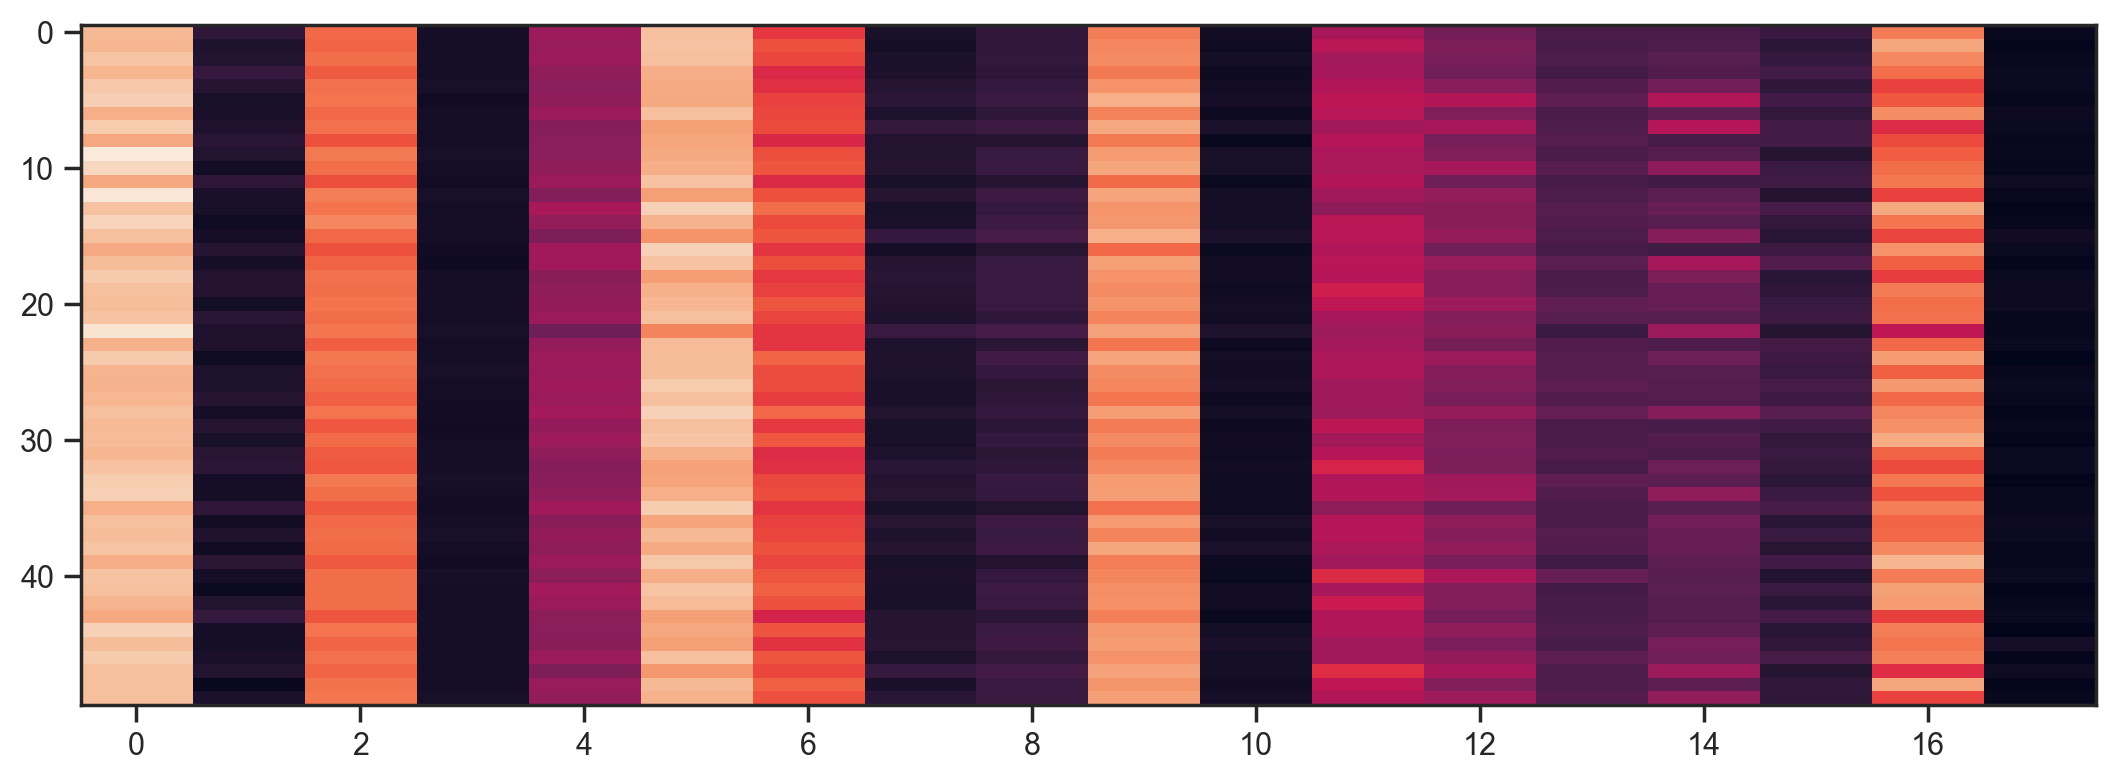

In [745]:
imshow(responses, aspect='auto')
figure()
imshow(responses_pred, aspect='auto')

responses_pred[:, 17] = means[17]

In [746]:
responses_pred.shape

(50, 18)

In [747]:
new_test = test.copy()

for i in range(responses.shape[1]):
    new_test.iloc[:, i+1] = responses_pred[:, i]

In [748]:
new_test.to_csv('../data/output_umap_pca.csv', index=False)